- **Author:** [Dace Apšvalka](https://www.mrc-cbu.cam.ac.uk/people/dace.apsvalka/) 
- **Date:** August 2024  
- **conda environment**: I used the [fMRI workshop's conda environment](https://github.com/MRC-CBU/COGNESTIC/blob/main/mri_environment.yml) to run this notebook and any accompanied scripts.

# fMRI Data Analysis: Subject-Level Analysis

Once our data has been pre-processed, we can proceed to the analysis. In this tutorial, we will focus on subject-level (or first-level) fMRI data analysis using [Nilearn](https://nilearn.github.io/stable/index.html). This process involves constructing a design matrix, fitting the model to the data, and computing beta maps (i.e., the estimated response for each condition) and contrast maps. Subject-level analysis is a crucial step before progressing to group-level analysis.

For analysing fMRI data, we commonly use general linear model (GLM). A GLM in fMRI analysis has the **BOLD signal** as the **dependent** or **outcome** variable (derived from the functional MRI images) and **predictors** or **independent variables** such as **events** (e.g., task conditions) and **confounds** (e.g., motion parameters). Typically analysis is performed by constructing a separate model for each voxel - a mass univariate approach. 

For more information on GLM, please see Rik's Stats tutorial!

And here are some recommended short videos to help better understand the principles of fMRI analysis:

In [18]:
from IPython.display import display, HTML

display(HTML('''
<div style="width: 1200px; margin: 0 auto; display: flex; justify-content: space-around;">
    <div style="text-align: center;">
        <h3>GLM applied to fMRI (11 min)</h3>
        <iframe width="560" height="315" src="https://www.youtube.com/embed/OyLKMb9FNhg" frameborder="0" allow="picture-in-picture" allowfullscreen></iframe>
    </div>
    <div style="text-align: center;">
        <h3>Conditions and contrasts (12 min)</h3>
        <iframe width="560" height="315" src="https://www.youtube.com/embed/7MibM1ATai4" frameborder="0" allow="picture-in-picture" allowfullscreen></iframe>
    </div>
</div>

<div style="width: 1200px; margin: 0 auto; display: flex; justify-content: space-around;">
    <div style="text-align: center;">
        <h3>Nuisance variables (14 min)</h3>
        <iframe width="560" height="315" src="https://www.youtube.com/embed/DEtwsFdFwYc" frameborder="0" allow="picture-in-picture" allowfullscreen></iframe>
    </div>
    <div style="text-align: center;">
        <h3>Multiple Comparisons (9 min)</h3>
        <iframe width="560" height="315" src="https://www.youtube.com/embed/AalIM9-5-Pk" frameborder="0" allow="picture-in-picture" allowfullscreen></iframe>
    </div>
</div>
'''))


----------------

**Table of contents**<a id='toc0_'></a>    
1. [Import required packages](#toc1_)    
2. [Retrieve the preprocessed (fMRIprep) data](#toc2_)    
3. [Setting up GLM model components](#toc3_)    
3.1. [Dependent variable: BOLD signal from each voxel of the functional MRI images](#toc3_1_)    
3.2. [Predictors: Events](#toc3_2_)    
3.3. [Predictors: Confounds](#toc3_3_)    
4. [Performing the GLM analysis](#toc4_)    
4.1. [Creating the First Level Model](#toc4_1_)    
4.2. [Fitting the model](#toc4_2_)    
4.3. [Inspecting the Design Matrix](#toc4_3_)    
5. [Contrast specification](#toc5_)    
5.1. [A simple case contrast](#toc5_1_)    
5.2. [Contrast scaling](#toc5_2_)    
5.3. [Scaled contrasts for comparing conditions](#toc5_3_)    
6. [Computing contrasts and plotting result maps](#toc6_)    
6.1. [Statistical signifiance testing](#toc6_1_)    
6.2. [Control the false positive rate](#toc6_2_)    
6.3. [False Discovery Rate (FDR) correction](#toc6_3_)    
6.4. [Cluster threshold](#toc6_4_)    
6.5. [The impact of first-level model parameters](#toc6_5_)    
7. [First Level for multiple subjects](#toc7_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=true
	minLevel=2
	maxLevel=3
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

-----------
## 1. <a id='toc1_'></a>[Import required packages](#toc0_)

In [19]:
# The conda environment used for this tutorial is available here: https://github.com/MRC-CBU/COGNESTIC/blob/main/mri_environment.yml 

import pandas as pd # for data manipulation
import numpy as np # for numerical operations

import matplotlib.pyplot as plt # for basic plotting

from bids.layout import BIDSLayout # to fetch data from BIDS-compliant datasets

# Nilearn modules, for the analysis of brain volumes, plotting, etc., https://nilearn.github.io/
from nilearn.glm.first_level import FirstLevelModel, glover_hrf, spm_hrf
from nilearn.glm.thresholding import threshold_stats_img
from nilearn.plotting import plot_design_matrix, plot_contrast_matrix, plot_stat_map

import warnings # to suppress warnings

from IPython.display import YouTubeVideo # to embed YouTube videos

## 2. <a id='toc2_'></a>[Retrieve the preprocessed (fMRIprep) data](#toc0_)

BIDS applications, such as `fMRIprep`, output data into a data structure similar to `BIDS` organization principals. And these data can also be inspected using [PyBIDS](https://bids-standard.github.io/pybids/index.html).


In [20]:
# --- Set up the paths to the BIDS data directory which includes derivatives
fmri_data_dir = 'FaceProcessing/data' # data in BIDS format

# --- Set up the BIDS layoutt and include the derivatives in it
layout = BIDSLayout(fmri_data_dir, derivatives = True)

# or to include only a specific derivatives folder
# layout = BIDSLayout(fmri_data_dir, derivatives = 'path/to/derivatives')


## 3. <a id='toc3_'></a>[Setting up GLM model components](#toc0_)

### 3.1. <a id='toc3_1_'></a>[Dependent variable: BOLD signal from each voxel of the functional MRI images](#toc0_)

We need to specify which MRI images we want to analyze. Here, we will analyze a single subject's **9 functional runs**. With `PyBIDS`, we can easily locate the preprocessed files needed for the analysis. Let's retrieve the preprocessed functional image files for **subject sub-04**.

In [21]:
sID = '04'

bold = layout.get(
    subject = sID, 
    datatype = 'func', 
    desc = 'preproc', 
    extension = '.nii.gz',
    return_type = 'filename'
)

print('\nSubject''s', sID, 'preprocessed functional images:')
print(*bold, sep='\n')


Subjects 04 preprocessed functional images:
/home/cognestic/COGNESTIC/05_fMRI/FaceProcessing/data/derivatives/fmriprep/sub-04/func/sub-04_task-faceprocessing_run-1_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz
/home/cognestic/COGNESTIC/05_fMRI/FaceProcessing/data/derivatives/fmriprep/sub-04/func/sub-04_task-faceprocessing_run-2_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz
/home/cognestic/COGNESTIC/05_fMRI/FaceProcessing/data/derivatives/fmriprep/sub-04/func/sub-04_task-faceprocessing_run-3_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz
/home/cognestic/COGNESTIC/05_fMRI/FaceProcessing/data/derivatives/fmriprep/sub-04/func/sub-04_task-faceprocessing_run-4_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz
/home/cognestic/COGNESTIC/05_fMRI/FaceProcessing/data/derivatives/fmriprep/sub-04/func/sub-04_task-faceprocessing_run-5_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz
/home/cognestic/COGNESTIC/05_fMRI/FaceProcessing/data/derivatives/fmri

We will also specify the subject's anatomical image (warped to the standard space) to use it as a background image when plotting results. 

In [22]:
anat = layout.get(
    subject = sID, 
    datatype = 'anat', 
    space = 'MNI152NLin2009cAsym', 
    desc = 'preproc', 
    extension = '.nii.gz',
    return_type ='filename'
)

print('Subject''s', sID, 'preprocessed anatomical image:')
print(*anat, sep='\n')

Subjects 04 preprocessed anatomical image:
/home/cognestic/COGNESTIC/05_fMRI/FaceProcessing/data/derivatives/fmriprep/sub-04/anat/sub-04_space-MNI152NLin2009cAsym_res-2_desc-preproc_T1w.nii.gz


### 3.2. <a id='toc3_2_'></a>[Predictors: Events](#toc0_)

We also need to specify the events that occurred during the functional acquisitions. The event files are stored in the `data/func` folder, and again, we can use `PyBIDS` to locate them.

In [23]:
events = layout.get(
    subject = sID, 
    datatype = 'func', 
    suffix = 'events', 
    extension = ".tsv", 
    return_type = 'filename'
)
print('Subject''s', sID, 'event files:')
print(*events, sep='\n')

Subjects 04 event files:
/home/cognestic/COGNESTIC/05_fMRI/FaceProcessing/data/sub-04/func/sub-04_task-faceprocessing_run-01_events.tsv
/home/cognestic/COGNESTIC/05_fMRI/FaceProcessing/data/sub-04/func/sub-04_task-faceprocessing_run-02_events.tsv
/home/cognestic/COGNESTIC/05_fMRI/FaceProcessing/data/sub-04/func/sub-04_task-faceprocessing_run-03_events.tsv
/home/cognestic/COGNESTIC/05_fMRI/FaceProcessing/data/sub-04/func/sub-04_task-faceprocessing_run-04_events.tsv
/home/cognestic/COGNESTIC/05_fMRI/FaceProcessing/data/sub-04/func/sub-04_task-faceprocessing_run-05_events.tsv
/home/cognestic/COGNESTIC/05_fMRI/FaceProcessing/data/sub-04/func/sub-04_task-faceprocessing_run-06_events.tsv
/home/cognestic/COGNESTIC/05_fMRI/FaceProcessing/data/sub-04/func/sub-04_task-faceprocessing_run-07_events.tsv
/home/cognestic/COGNESTIC/05_fMRI/FaceProcessing/data/sub-04/func/sub-04_task-faceprocessing_run-08_events.tsv
/home/cognestic/COGNESTIC/05_fMRI/FaceProcessing/data/sub-04/func/sub-04_task-faceproce

### 3.3. <a id='toc3_3_'></a>[Predictors: Confounds](#toc0_)

Confounds represent fluctuations with a potential non-neuronal origin, such as head motion artifacts, scanner noise, and cardiac or respiratory effects. We can include them in the GLM as regressors of no interest to minimize the confounding effects of non-neuronal signals. fMRIPrep calculates a wide range of possible confounds. You can find detailed information in the [fMRIPrep documentation](https://fmriprep.org/en/stable/outputs.html#confounds).

Which confounding variables you include in the GLM depends on the analysis you want to perform. The most well-established confounds are the six head-motion parameters (three rotations and three translations). If your dataset includes physiological recordings (e.g., heart rate, respiration), you might consider including these as confounds. If not, you might include PCA components from CompCor, a method implemented in fMRIPrep that identifies noise components from CSF and white matter signals. **However, please read the fMRIPrep documentation on confounds carefully before including any additional confounds, and never include all confounds in the GLM design matrix!**

If your study has specific considerations (e.g., participant behavior or task-related noise), you may need to include additional custom confounds.

The confounds computed by `fMRIPrep` can be found in the `data/derivatives/fmriprep/{sub}/func/ directory`. They are stored separately for each run in `.tsv` files, with one column for each confound variable. Let's use `PyBIDS` to locate these files.

In [24]:
confounds = layout.get(
    subject = sID, 
    datatype = 'func', 
    desc = 'confounds', 
    extension = ".tsv", 
    return_type = 'filename'
)

print('Subject''s', sID, 'confound files:')
print(*confounds, sep='\n')

Subjects 04 confound files:
/home/cognestic/COGNESTIC/05_fMRI/FaceProcessing/data/derivatives/fmriprep/sub-04/func/sub-04_task-faceprocessing_run-1_desc-confounds_timeseries.tsv
/home/cognestic/COGNESTIC/05_fMRI/FaceProcessing/data/derivatives/fmriprep/sub-04/func/sub-04_task-faceprocessing_run-2_desc-confounds_timeseries.tsv
/home/cognestic/COGNESTIC/05_fMRI/FaceProcessing/data/derivatives/fmriprep/sub-04/func/sub-04_task-faceprocessing_run-3_desc-confounds_timeseries.tsv
/home/cognestic/COGNESTIC/05_fMRI/FaceProcessing/data/derivatives/fmriprep/sub-04/func/sub-04_task-faceprocessing_run-4_desc-confounds_timeseries.tsv
/home/cognestic/COGNESTIC/05_fMRI/FaceProcessing/data/derivatives/fmriprep/sub-04/func/sub-04_task-faceprocessing_run-5_desc-confounds_timeseries.tsv
/home/cognestic/COGNESTIC/05_fMRI/FaceProcessing/data/derivatives/fmriprep/sub-04/func/sub-04_task-faceprocessing_run-6_desc-confounds_timeseries.tsv
/home/cognestic/COGNESTIC/05_fMRI/FaceProcessing/data/derivatives/fmripr

Let's get a list of all confounds of the first functional run. 

In [25]:
confounds_run1 = pd.read_table(confounds[0])

print('Number of confounds in run 1:', len(list(confounds_run1)))
print(*list(confounds_run1), sep='\n')


Number of confounds in run 1: 184
global_signal
global_signal_derivative1
global_signal_derivative1_power2
global_signal_power2
csf
csf_derivative1
csf_power2
csf_derivative1_power2
white_matter
white_matter_derivative1
white_matter_power2
white_matter_derivative1_power2
csf_wm
tcompcor
std_dvars
dvars
framewise_displacement
rmsd
t_comp_cor_00
t_comp_cor_01
t_comp_cor_02
t_comp_cor_03
t_comp_cor_04
c_comp_cor_00
c_comp_cor_01
c_comp_cor_02
c_comp_cor_03
c_comp_cor_04
c_comp_cor_05
c_comp_cor_06
c_comp_cor_07
w_comp_cor_00
w_comp_cor_01
w_comp_cor_02
w_comp_cor_03
w_comp_cor_04
w_comp_cor_05
w_comp_cor_06
w_comp_cor_07
w_comp_cor_08
w_comp_cor_09
w_comp_cor_10
w_comp_cor_11
w_comp_cor_12
w_comp_cor_13
w_comp_cor_14
w_comp_cor_15
w_comp_cor_16
w_comp_cor_17
w_comp_cor_18
w_comp_cor_19
w_comp_cor_20
w_comp_cor_21
w_comp_cor_22
w_comp_cor_23
w_comp_cor_24
w_comp_cor_25
w_comp_cor_26
w_comp_cor_27
w_comp_cor_28
w_comp_cor_29
w_comp_cor_30
w_comp_cor_31
w_comp_cor_32
w_comp_cor_33
w_comp_cor

In this example, we will include the most commonly used confounds—the six motion parameters.

**If your data contains dummy scans and you specified this when running fMRIPrep, dummy scan confounds (non_steady_state_outlier##) will also be generated, and you must include them in your GLM!** This ensures that the dummy volumes do not contribute to the parameter estimates.

We had two dummy scans, so we will include the two *'non_steady_state_outliers'* in our design.

In [26]:
confounds_of_interest = ['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z', 'non_steady_state_outlier00', 'non_steady_state_outlier01']

Let's display the confounds of interest of the first run.

In [27]:
confounds_run1[confounds_of_interest]

,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z,non_steady_state_outlier00,non_steady_state_outlier01
0,0.033547,-0.058347,-0.073652,-0.001004,0.000472,-0.000519,1.0,0.0
1,0.025235,-0.017269,-0.048056,-0.001031,0.000381,-0.000519,0.0,1.0
2,0.029830,-0.010516,-0.055210,-0.001199,0.000488,-0.000519,0.0,0.0
3,0.019524,0.053883,-0.034148,-0.001755,0.000687,-0.000519,0.0,0.0
4,0.013442,-0.000504,-0.030142,-0.001672,0.000526,-0.000519,0.0,0.0
...,...,...,...,...,...,...,...,...
205,-0.073486,0.100237,-0.046184,0.002650,0.000023,-0.000497,0.0,0.0
206,-0.073488,0.191561,-0.032208,0.002221,-0.000028,-0.000497,0.0,0.0
207,-0.063061,0.061900,-0.031723,0.003162,-0.000337,-0.000622,0.0,0.0
208,-0.064975,0.212292,0.004795,0.002401,-0.000241,-0.000553,0.0,0.0


Now, we need to extract the confounds of interest from all nine runs. We will include these in our GLM model by creating a list of confound tables, resulting in a list of nine tables.

In [28]:
confounds_glm = []
for conf_file in confounds:
    this_conf = pd.read_table(conf_file)
    conf_subset = this_conf[confounds_of_interest].fillna(0) # replace NaN with 0
    confounds_glm.append(conf_subset)

Now we have the BOLD images, event files, and confounds for each of the 9 functional runs. Nilearn will analyse them together and compute fixed effects statistics for this subject. 

## 4. <a id='toc4_'></a>[Performing the GLM analysis](#toc0_)

It is now time to create and estimate a `FirstLevelModel` object, which will generate our *design matrix* based on the inputs we have provided.



### 4.1. <a id='toc4_1_'></a>[Creating the First Level Model](#toc0_)

Now we can specify the model with the parameters of our choice (see the [documentation](https://nilearn.github.io/stable/modules/generated/nilearn.glm.first_level.FirstLevelModel.html) for a full list of parameters). Here we will specify the folowing:
* **t_r** - repetition time (the sampling interval of the functional runs) in seconds. We can get it from our BIDS layout.

In [29]:
# Get the TR
TR = layout.get_tr()
print('TR:', TR)

TR: 2.0


* **slice_time_ref**: *This parameter indicates the time of the reference slice used in the slice timing preprocessing step of the experimental runs. It is expressed as a percentage of the t_r (time repetition), so it can have values between 0. and 1. Default=0.* 
  
  We can find this information in our fMRIPrep Methods (*data/derivatives/fmriprep/logs/CITATION.html*). There we read: *"BOLD runs were slice-time corrected to 0.974s (0.5 of slice acquisition range 0s-1.95s)"*. This means, that **0.5** is the value we need to use for this parameter. 
  
  Alternativel, and perhaps preferably, we can obtain this information from the BIDS derivatives metadata. It also tells if the slice-time correction was performed at all. 

  *data\derivatives\fmriprep\sub-{sID}\func\sub-{sID}_task-facerecognition_run-{runID}_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.json*
  ```json
  {
    "RepetitionTime": 2,
    "SkullStripped": false,
    "SliceTimingCorrected": true,
    "StartTime": 0.974,
    "TaskName": "facerecognition"
  } 
```

In [30]:
# If slice timing correction was applied, get the slice time reference
slice_timing = layout.get_metadata(bold[0])
if slice_timing['SliceTimingCorrected']:
  slice_time_ref = slice_timing['StartTime'] / TR
  print('Slice timing reference:', slice_time_ref)
else:
  slice_time_ref = 0
  print('Slice timing correction was not applied')

Slice timing reference: 0.487


* **hrf_model**: defines the HRF model to be used. Possible options:
  * `spm`: This is the HRF model used in SPM. 
  * `spm + derivative`: SPM model plus its time derivative. This gives 2 regressors.
  * `spm + derivative + dispersion`: Idem, plus dispersion derivative. This gives 3 regressors.
  * `glover`: This corresponds to the Glover HRF.
  * `glover + derivative`: The Glover HRF + time derivative. This gives 2 regressors. 
  * `glover + derivative + dispersion`: Idem, plus dispersion derivative. This gives 3 regressors. 
  * `fir`: Finite impulse response basis. This is a set of delayed dirac models.

It can also be a custom model. In this case, a function should be provided for each regressor.
  
The choice of the HRF model is up to the user. There's little difference between using the SPM or Glover model. It's advisable to include derivatives when there's some uncertainty in the timing information, as this can help identify timing problems more effectively.

Let's see how, for example, SPM and Glover HRFs compare.

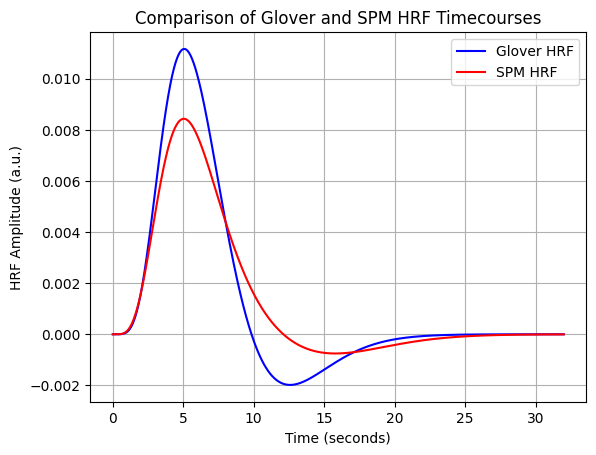

In [31]:
# modeled time in seconds
time_length = 32

# Generate the HRF timecourses
glover_timecourse = glover_hrf(TR, time_length=time_length)
spm_timecourse = spm_hrf(TR, time_length=time_length)

# Plot the timecourses
timepoints = np.linspace(0, time_length, num=len(glover_timecourse))
plt.plot(timepoints, glover_timecourse, label='Glover HRF', color='blue')
plt.plot(timepoints, spm_timecourse, label='SPM HRF', color='red')
plt.title('Comparison of Glover and SPM HRF Timecourses')
plt.xlabel('Time (seconds)')
plt.ylabel('HRF Amplitude (a.u.)')
plt.legend()
plt.grid(True)
plt.show()

* **drift_model**: specifies the desired drift model for the design matrices. It can be ‘polynomial’, ‘cosine’ or None. Default=’cosine’.
* **high_pass**: specifies the cut frequency of the high-pass filter in Hz for the design matrices. Used only if drift_model is ‘cosine’. Default=0.01 (1/128, as in SPM).
* **smoothing_fwhm**: the full-width at half maximum in millimeters of the spatial smoothing to apply to the signal (smoothing was not done in fMRIPrep!).
* **noise_model**: {‘ar1’, ‘ols’} The temporal variance model. Default=’ar1’.

In [32]:
fmri_glm = FirstLevelModel(
    t_r = TR,
    slice_time_ref = slice_time_ref,
    smoothing_fwhm = 6, # a rule of thumb is 3x the voxel size
    hrf_model = 'glover', # default
    drift_model = 'cosine', # default
    high_pass = 0.01, # default; Used only if drift_model is ‘cosine’
    noise_model = 'ar1', # default
   # mask_img = path_to_mask_image, # default is None and Nilearn will compute it
)

### 4.2. <a id='toc4_2_'></a>[Fitting the model](#toc0_)

Now that we have specified the model, we can run it on our data. We need to include the list of our functional image files (we named them `bold)`, the list of event timing files (we named them `events`), and the list of our confound tables (one per run, named `confounds_glm`).

In [33]:
fmri_glm = fmri_glm.fit(bold, events, confounds_glm)

/cognestic/miniconda3/envs/mri/lib/python3.11/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: button_pushed, circle_duration, stim_file, trigger, response_time
  warnings.warn(
/cognestic/miniconda3/envs/mri/lib/python3.11/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: button_pushed, circle_duration, stim_file, trigger, response_time
  warnings.warn(
/cognestic/miniconda3/envs/mri/lib/python3.11/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: button_pushed, circle_duration, stim_file, trigger, response_time
  warnings.warn(
/cognestic/miniconda3/envs/mri/lib/python3.11/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data 

### 4.3. <a id='toc4_3_'></a>[Inspecting the Design Matrix](#toc0_)

We can now inspect the design matrix of our GLM model (rows represent time, and columns contain the predictors).

The `design_matrices` is a list of 9 tables (one per run). Let's look at the first run's design matrix.

In [ ]:
# get the design matrices from the glm model
design_matrices = fmri_glm.design_matrices_

# display the design matrix of the first run
design_matrices[0]

From the design matrix, we can extract and plot the expected signal of our conditions. Here we will plot it for the first run.

In [ ]:
dm = design_matrices[0][['FAMOUS_1', 'SCRAMBLED_1', 'UNFAMILIAR_1']]
dm.columns.name = 'Condition'
dm.index.name = 'Seconds'
dm.plot(figsize=(12,4), title='Expected responses per condition')

**Q: How was this expected signal obtained?**

If we plot all predicted event responses, we can observe the expected oscillations. Any slow oscillations (modelled by the cosine function) will be filtered out.

In [ ]:
dm = design_matrices[0]
event_regressors = dm.columns[:9]
noise_regressors = [col for col in dm.columns if col.startswith('drift_')]

plt.figure(figsize=(12, 6))

# Plot the predicted event responses
for event in event_regressors:
    plt.plot(dm.index, dm[event], label=event, color='lightblue')

# Plot the modeled noise
for drift in noise_regressors:
    plt.plot(dm.index, dm[drift], color='grey', lw=1, alpha=0.7)
 
plt.show()

We can also plot the actual design matrix. Let's plot it for the first run. 

In [ ]:
print('Design matrix for run', 1)
plot_design_matrix(design_matrices[0], output_file=None)

fig = plt.gcf()
fig.set_size_inches(8,2)
plt.show()

It seems that the non-steady-state volume 'spoils the image'. It's good that we are excluding it from our analysis.

## 5. <a id='toc5_'></a>[Contrast specification](#toc0_)

If we have the same number of regressors, in the same order, in each run, we can specify the contrast for one run, and it will automatically be reused for the other runs. However, to be cautious, it's advisable to define contrasts separately for each run.

### 5.1. <a id='toc5_1_'></a>[A simple case contrast](#toc0_)

In [ ]:
# A simple case contrast

n_columns = design_matrices[0].shape[1]  # Number of predictors in the model

contrasts = {
    'Faces_Scrambled': np.pad([1, 1, 1, -2, -2, -2, 1, 1, 1], (0, n_columns - 9), 'constant'),
    'Famous_Unfamiliar': np.pad([1, 1, 1, 0, 0, 0, -1, -1, -1], (0, n_columns - 9), 'constant'),
    'EffectsOfInterest': np.eye(n_columns)[:9]  
}


In [ ]:
for key, values in contrasts.items():
    plot_contrast_matrix(values, design_matrix=design_matrices[0])
    plt.suptitle(key)

plt.show()

### 5.2. <a id='toc5_2_'></a>[Contrast scaling](#toc0_)

A GLM is a linear combination of predictor beta coefficients, where each beta represents the weight or contribution of a given predictor to the overall model.

For example, if we have conditions (predictors): Famous, Unfamiliar, and Scrambled, a contrast estimating Faces vs. Scrambled with weights [1, 1, -2] would calculate Famous + Unfamiliar - 2 * Scrambled. This can be interpreted as the sum of the responses to Famous and Unfamiliar faces, minus twice the response to Scrambled faces. However, what we typically want is the average response to Famous and Unfamiliar faces minus the response to Scrambled faces. To achieve this, we would need to scale the contrast as follows: [0.5, 0.5, -1].

Scaling contrast weights affects the magnitude of the resulting contrast estimate, but not the t-values or p-values, so the statistical inference remains unchanged. However, contrast estimates that reflect averages rather than sums are generally more meaningful for interpretation.

If we want to obtain beta estimates for each condition separately (e.g., a beta estimate for Famous, a beta estimate for Unfamiliar, etc.), and we have multiple functional runs, we need to scale the contrast to account for the number of runs to get the average beta across them. When scaled appropriately, we can report the result as a 'beta estimate' rather than just a 'contrast estimate,' since scaling allows the contrast to represent the average of the beta estimates. This average can then be interpreted directly as a beta estimate for the condition.

In [ ]:
# A contrast scaling function, which scales for the number of conditions and runs

def scale_contrast(contrast_vector, nruns):
    positive_sum = np.sum(contrast_vector[contrast_vector > 0])  # Sum of positive weights
    negative_sum = np.abs(np.sum(contrast_vector[contrast_vector < 0]))  # Sum of negative weights (absolute)
    
    # Scale each part of the vector separately
    scaled_vector = np.zeros_like(contrast_vector, dtype=float)
    scaled_vector[contrast_vector > 0] = contrast_vector[contrast_vector > 0] / (positive_sum * nruns)
    scaled_vector[contrast_vector < 0] = contrast_vector[contrast_vector < 0] / (negative_sum * nruns)
    
    return scaled_vector


In [ ]:
example_contrast = np.array([1, 1, 1, -2, -2, -2, 1, 1, 1])
print('\n Original contrast:\n', example_contrast)
print('\n Scaled contrast for one run:\n', scale_contrast(example_contrast, 1))
print('\n Scaled contrast for nine runs:\n', scale_contrast(example_contrast, 9))

### 5.3. <a id='toc5_3_'></a>[Scaled contrasts for comparing conditions](#toc0_)

In [ ]:
n_columns = design_matrices[0].shape[1]  # Number of predictors in the model
nruns = len(design_matrices)  # Number of runs

contrast_list = []

# Define the contrasts and scale them
contrasts = {
    'Faces_Scrambled': scale_contrast(np.pad([1, 1, 1, -2, -2, -2, 1, 1, 1], (0, n_columns - 9), 'constant'), nruns),
    'Famous_Unfamiliar': scale_contrast(np.pad([1, 1, 1, 0, 0, 0, -1, -1, -1], (0, n_columns - 9), 'constant'), nruns),
    'EffectsOfInterest': np.eye(n_columns)[:9]  # No scaling needed here
}


### Scaled contrasts for each condition of interest

In [ ]:
# Create contrasts
design_matrices = fmri_glm.design_matrices_

# Create contrasts for all unique conditions
events_df = pd.read_table(events[0])
unique_conditions = events_df['trial_type'].unique()

#contrast_list = []
nruns = len(design_matrices)

for design_matrix in design_matrices:
    n_columns = design_matrix.shape[1]  # number of predictors in the model
    column_names = design_matrix.columns  # get the names of the columns
    
    # Create an empty dictionary to store contrasts for all conditions
    #contrasts = {}
    
    for condition in unique_conditions:
        # Initialize the contrast vector with zeros
        contrast_vector = np.zeros(n_columns)
        
        # Assign 1 to the columns that correspond to the current condition
        for i, col_name in enumerate(column_names):
            if col_name.startswith(condition):
                contrast_vector[i] = 1/nruns
        
        # Store the contrast for the current condition
        contrasts[condition] = contrast_vector    
    
    # Append all contrasts for this design matrix
    contrast_list.append(contrasts)

In [ ]:
for key, values in contrast_list[0].items():
    plot_contrast_matrix(values, design_matrix=design_matrices[0])
    plt.suptitle(key)

plt.show()

## 6. <a id='toc6_'></a>[Computing contrasts and plotting result maps](#toc0_)

With Nilearn, you can compute the `effect size` maps, `t-statistics` maps, `z-scores` and some other types. See the [documentation](https://nilearn.github.io/dev/modules/generated/nilearn.glm.Contrast.html) for more information.

'Effect size' maps correspond to the 'beta' (or contrast estimate) maps. These can be used, for example, to plot effect sizes (beta estimates) in ROI analysis (see examples in the ROI analysis notebook), or as inputs for group-level analysis. 

In the case of a single-subject analysis, let's look at z-scored maps for **Faces > Scrambled contrast**. 

In [ ]:
z_map = fmri_glm.compute_contrast(
    [c['Faces_Scrambled'] for c in contrast_list],
    output_type = 'z_score'
)

# You can sace the z_map to a file
# z_map.to_filename('/path/to/output/z_map.nii.gz')

### 6.1. <a id='toc6_1_'></a>[Statistical signifiance testing](#toc0_)

fMRI analyses involve thousands of voxel-wise comparisons, which increases the risk of false positives—illustrated by the well-known case of the ["Dead Salmon"](https://teenspecies.github.io/pdfs/NeuralCorrelates.pdf).

Applying a threshold, especially one that corrects for multiple comparisons (e.g., using Family-Wise Error (FWE) or False Discovery Rate (FDR) corrections), ensures that the displayed activations are statistically reliable.

### 6.2. <a id='toc6_2_'></a>[Control the false positive rate](#toc0_)

A minimum recommendation is to control the **false positive rate** (fpr) at a specific threshold, such as p < .001. This is referred to as 'uncorrected' because it does not account for or correct the number of multiple comparisons, but it can still help reduce false positives to a reasonable level when applied conservatively.

In [ ]:
# Obtain the statistical threshold
_, threshold_fpr = threshold_stats_img(
    z_map, 
    alpha = .001, 
    height_control = 'fpr'
)

print('Uncorrected p<.001 threshold: %.3f' % threshold_fpr)

# plot the thresholded map
plot_stat_map(
    z_map, 
    bg_img = anat[0], 
    threshold = threshold_fpr,
    display_mode = 'ortho', 
    black_bg = True,
    title = 'Faces > Scrambled  (p<.001, uncorrected)'
)
plt.show()

### 6.3. <a id='toc6_3_'></a>[False Discovery Rate (FDR) correction](#toc0_)

A commonly used alternative to controlling the false positive rate is the **False Discovery Rate** (FDR) method, which addresses the expected proportion of false discoveries among all detected activations. However, in neuroimaging research, the appropriateness of FDR remains a topic of debate. While it is often preferred in exploratory or hypothesis-generating studies due to its balance between discovery and error control, it may be less suitable for confirmatory studies where stricter error control is required.

In [ ]:
_, threshold_fdr = threshold_stats_img(
    z_map, 
    alpha = .05, 
    height_control = 'fdr'
)

print('FDR, p<.05 threshold: %.3f' % threshold_fdr)

plot_stat_map(
    z_map, 
    bg_img = anat[0], 
    threshold = threshold_fdr,
    display_mode = 'ortho', 
    black_bg = True,
    title = 'Faces > Scrambled  (p<.05, FDR corrected)'
)
plt.show()

#### Family Wise Error (FWE) correction

A more conservative approach is to control the **family-wise error** (FWE) rate, which represents the probability of making one or more false discoveries, or Type I errors, across all tests. This rate is typically set at 5%. The **Bonferroni correction** is a commonly used method to achieve this level of control and is also used in Nilearn. 

In Nilearn, Bonferroni correction is applied to the number of voxels. The Bonferroni correction, when applied directly to the number of voxels, is not appropriate for fMRI data. This is because neuroimaging data typically have spatially correlated data points, which violate the Bonferroni assumption of independent tests (even more so if data have been smoothed). As an alternative, neuroscientists have developed **Random Field Theory** (RFT). This method accounts for the spatial correlation by applying multiple comparison correction in a way that considers the smoothness of the data. Specifically, the correction is applied to the number of '***resels'*** (RESolution ELements), rather than the raw number of voxels. However, it's important to note that this RFT-based approach is not implemented in Nilearn. 
At the second-level analysis, Nilearn provides an option for non-parametric inference with permutation testing, which is a more suitable approach for fMRI data when considering the spatial correlation of voxels. 

In [ ]:
_, threshold_fwe = threshold_stats_img(
    z_map, 
    alpha = .05, 
    height_control = 'bonferroni')

print('Bonferroni-corrected, p<.05 threshold: %.3f' % threshold_fwe)

plot_stat_map(
    z_map, 
    bg_img = anat[0], 
    threshold = threshold_fwe,
    display_mode = 'ortho', 
    black_bg = True,
    title = 'Faces > Scrambled  (p<.05, FWE corrected)'
)
plt.show()

### 6.4. <a id='toc6_4_'></a>[Cluster threshold](#toc0_)

It's a common practice to discard isolated voxels from the images. It is possible to generate a thresholded map with small clusters removed by providing a `cluster_threshold` argument. Here clusters smaller than `20` voxels will be discarded from the `fpr` corrected map.

In [ ]:
thresholded_map_fpr, threshold_fpr = threshold_stats_img(
    z_map, 
    alpha = .001, 
    height_control='fpr', 
    cluster_threshold = 20
)

plot_stat_map(
    thresholded_map_fpr, 
    bg_img = anat[0], 
    threshold = threshold_fpr,
    display_mode = 'ortho', 
    black_bg = True, 
    colorbar = True,
    title = 'Faces > Scrambled (p<.001, uncorrected, k=20'
)
plt.show()

### 6.5. <a id='toc6_5_'></a>[The impact of first-level model parameters](#toc0_)

See the Nilearn tutorial for more examples on how the first_level parameters impact the results: https://nilearn.github.io/stable/auto_examples/04_glm_first_level/plot_first_level_details.html

Here we will just compare our original model where we used Glover's HRF to a model SPM's HRF. 

#### Model 1: Glover's HRF

In [ ]:
"""
fmri_glm = FirstLevelModel(
    t_r = TR,
    slice_time_ref = slice_time_ref,
    smoothing_fwhm = 6,
    hrf_model = 'glover',
    drift_model = 'cosine', 
    high_pass = 0.01, 
    noise_model = 'ar1'
)

fmri_glm = fmri_glm.fit(bold, events, confounds_glm)

"""

In [ ]:
model1_z_map = z_map
model1_title = 'Glover HRF model, Faces > Scrambled'

#### Model 2: SPM's HRF

In [ ]:
fmri_glm2 = FirstLevelModel(
    t_r = TR,
    slice_time_ref = slice_time_ref,
    smoothing_fwhm = 6,
    hrf_model = 'spm',
    drift_model = 'cosine', 
    high_pass = 0.01, 
    noise_model = 'ar1'
)

fmri_glm2 = fmri_glm2.fit(bold, events, confounds_glm)


This model has the same regressors as model1, therefore we can use our original (model1) contrasts.

In [ ]:
model2_z_map = fmri_glm2.compute_contrast(
  [c['Faces_Scrambled'] for c in contrast_list],
  output_type='z_score')

model2_title = 'SPM HRF model, Faces > Scrambled'

#### Plotting both models

In [ ]:
z_maps = [model1_z_map, model2_z_map]
titles = [model1_title, model2_title]

for (z_map, title) in zip(z_maps, titles):
    _, threshold = threshold_stats_img(z_map, alpha = .001, height_control = 'fpr')
    plot_stat_map(z_map, bg_img = anat[0], threshold = threshold,
              display_mode = 'ortho', 
              cut_coords = [33, -72, -12],
              black_bg = True,
              title = title)
plt.show()

## 7. <a id='toc7_'></a>[First Level for multiple subjects](#toc0_)

Using a notebook like this is an effective method for preparing the final analysis script. Now, we can combine all the elements discussed into a unified, generic script that will conduct the first-level analysis.

**Example of a generic first-level script**: [code-examples/first_level_script.py](https://github.com/dcdace/fMRI_training/blob/main/code/first_level_script.py)

Things to note:
* We are saving the result files in BIDS format so that we can easily query them with PyBIDS for further analysis.
* We are generating this result model's dataset_description.json file, which is required to use the results directory as BIDS-compatible data. We will also save our model parameters in this file, which is very useful for understanding how the results were obtained.

```python
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
# ======================================================================
# Dace Apšvalka (MRC CBU 2024)
# Subject-level fMRI analysis using Nilearn
# 
# This script requres step08_first_level_analysis.sh, unless you define ds, sID, 
# and output here manually 
#
# ======================================================================

# ======================================================================
# IMPORT REQUIRED PACKAGES
# ======================================================================
import os
import sys
import pandas as pd
import numpy as np
from bids.layout import BIDSLayout
from nilearn.glm.first_level import FirstLevelModel
import time
import warnings
warnings.filterwarnings("ignore")

# ======================================================================
# DEFINE PATHS
# arguments passed from step08_first_level_analysis.sh
# ======================================================================

ds = sys.argv[1] # BIDS dataset location
sID = sys.argv[2].split("sub-")[1] # subject id
output = sys.argv[3]

# ======================================================================
print("Running first-level analysis for subject " + sID)
start_time = time.time()
print("Started at: " + time.strftime("%H:%M:%S", time.localtime()))

# ======================================================================
# DEFINE PARAMETERS
# =====================================================================
model_name = 'first-level'

bids_path = os.path.join(ds, 'data')

outdir = os.path.join(output, model_name, 'sub-' + sID)
if not os.path.exists(outdir):
    os.makedirs(outdir)

print("BIDS data location: " + bids_path)
print("Output directory: " + outdir)

# ======================================================================
# PERFORM SUBJECT LEVEL GLM ANALYSIS
# ======================================================================

# --- Initialize the BIDS layout and include the derivatives in it
layout = BIDSLayout(bids_path, derivatives=True)

# --- Get the preprocessed functional files
bold = layout.get(
    subject=sID, 
    datatype='func', 
    space='MNI152NLin2009cAsym', 
    desc='preproc', 
    extension='.nii.gz',
    return_type='filename'
    )
print("Found " + str(len(bold)) + " preprocessed functional files")

# --- Get the event files
events = layout.get(
    subject=sID, 
    datatype='func', 
    suffix='events', 
    extension=".tsv", 
    return_type='filename'
    )
print("Found " + str(len(events)) + " event files")

# --- Get the confounds and select which ones to include in the design
confounds = layout.get(
    subject=sID, 
    datatype='func', 
    desc='confounds', 
    extension=".tsv", 
    return_type='filename'
    )
print("Found " + str(len(confounds)) + " confounds files")

# --- Define which confounds to include in the GLM
confounds_of_interest = ['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z', 
                         'non_steady_state_outlier00', 'non_steady_state_outlier01']

# --- For each run, load the confounds and select the ones of interest
confounds_glm = []
for conf_file in confounds:
    this_conf = pd.read_table(conf_file)
    # only include the confounds of interest that are present in the file
    confounds_of_interest = [conf for conf in confounds_of_interest if conf in this_conf.columns]
    # select the confounds of interest and fill NaN with 0    
    conf_subset = this_conf[confounds_of_interest].fillna(0) # replace NaN with 0
    confounds_glm.append(conf_subset)

# --- Get the TR value
TR = layout.get_tr()

# --- If slice timing correction was applied, get the slice time reference
slice_timing = layout.get_metadata(bold[0])
if slice_timing['SliceTimingCorrected']:
  slice_time_ref = slice_timing['StartTime'] / TR
else:
  slice_time_ref = 0

# --- Define the GLM model
fmri_glm = FirstLevelModel(
    t_r = TR,
    slice_time_ref = slice_time_ref, 
    hrf_model = 'glover',
    drift_model = 'cosine',
    high_pass = 0.01,
    noise_model = 'ar1',
    smoothing_fwhm = 6
    )

# --- Fit the model
fmri_glm = fmri_glm.fit(bold, events, confounds_glm)

# --- Get the design matrices
design_matrices = fmri_glm.design_matrices_

# --- Create contrasts 
events_df = pd.read_table(events[0])
unique_conditions = events_df['trial_type'].unique()

contrast_list = []
nruns = len(design_matrices)

for design_matrix in design_matrices:
    n_columns = design_matrix.shape[1]  # number of predictors in the model
    column_names = design_matrix.columns  # get the names of the columns
    
    # Create an empty dictionary to store contrasts for all conditions
    contrasts = {}
    
    # ------------------------------------------------------------------
    # Create a contrast vector for each condition
    # ------------------------------------------------------------------
    for condition in unique_conditions:
        # Initialize the contrast vector with zeros
        contrast_vector = np.zeros(n_columns)
        
        # Assign 1 to the columns that correspond to the current condition and scale by the number of runs
        for i, col_name in enumerate(column_names):
            if col_name.startswith(condition):
                contrast_vector[i] = 1/nruns
        
        # Store the contrast for the current condition
        contrasts[condition] = contrast_vector
        
    # ------------------------------------------------------------------
    # Create contrast for Faces > Scrambled
    # ------------------------------------------------------------------
    # Calculate the number of "Faces" and "Scrambled" conditions
    num_faces = sum(1 for col_name in column_names if col_name.startswith(('FAMOUS', 'UNFAMILIAR')))
    num_scrambled = sum(1 for col_name in column_names if col_name.startswith('SCRAMBLED'))
    
    # Initialize the contrast vector with zeros
    contrast_vector = np.zeros(n_columns)
    
    # Assign weights to the contrast vector
    for i, col_name in enumerate(column_names):
        if col_name.startswith(('FAMOUS', 'UNFAMILIAR')):
            contrast_vector[i] = 1 / num_faces /nruns # weigh the faces conditions
        elif col_name.startswith('SCRAMBLED'):
            contrast_vector[i] = -1 / num_scrambled/nruns  # weigh the scrambled conditions
    
    contrasts['Faces_Scrambled'] = contrast_vector
    
    # ------------------------------------------------------------------
    # Create effects of interest contrast
    # ------------------------------------------------------------------
    contrasts['EffectsOfInterest'] = np.eye(n_columns)[:len(unique_conditions)]
    
    # Append all contrasts for this design matrix
    contrast_list.append(contrasts)
    
# --- Compute the contrasts and save the results
for contrast_id in contrast_list[0].keys():   
    if contrast_id == 'EffectsOfInterest':
        stats = 'z_score' 
    else:
        stats = 'effect_size'
    stats_map = fmri_glm.compute_contrast(
        [c[contrast_id] for c in contrast_list], 
        output_type = stats)
    # Save results following BIDS standart
    res_name = os.path.basename(bold[0]).split("run")[0]
    # from stats get only the part before _ for the BIDS file name
    stats_suffix = stats.split("_")[0]
    # in contrast_id remove underscores
    contrast_id = contrast_id.replace("_", "")
    # Save the result
    stats_map.to_filename(os.path.join(outdir, res_name + 'desc-' + contrast_id + '_' + stats_suffix + '.nii.gz'))

# ======================================================================
# CREATE THIS MODEL'S dataset_description.json FILE
# This is needed to use the results directory as BIDS data. 
# We will save our model parameters in the file as well, which is very useful.
# ======================================================================

jason_file = os.path.join(output, model_name, "dataset_description.json")

if not os.path.exists(jason_file):
    import json
    import datetime
    from importlib.metadata import version

    bids_version = layout.get_dataset_description()['BIDSVersion']
    nilearn_version = version('nilearn')
    date_created = datetime.datetime.now()
    
    # Data to be written
    content = {
        "Name": "First-level GLM analysis",
        "BIDSVersion": bids_version,
        "DatasetType": "results",
        "GeneratedBy": [
            {
                "Name": "Nilearn",
                "Version": nilearn_version,
                "CodeURL": "https://nilearn.github.io"
            }
        ],    
        "Date": date_created,
        "ConfoundsIncluded": confounds_of_interest,
        "FirstLevelModel": [
            fmri_glm.get_params()
        ], 
    }
    
    # Serializing json
    json_object = json.dumps(content, indent=4, default=str)
    
    # Writing to .json
    with open(jason_file, "w") as outfile:
        outfile.write(json_object)

# ======================================================================
print("Finished first-level analysis for subject " + sID)
print("Finished at: " + time.strftime("%H:%M:%S", time.localtime()))
print("Processing time: " + str(round((time.time() - start_time)/60, 2)) + " minutes")

```

I we have `SLURM` available on the system, we can write a project-specific script where we define the paths and use the `sbatch` command to execute the generic script for each subject in parallel using `SLURM`. 

**Example script to perform first-level analysis on multiple subjects**: [step08_first_level_analysis.sh](code-examples/step08_first_level_analysis.sh)